<a href="https://colab.research.google.com/github/Suhani2716/Wireless/blob/main/Research_paper_Model_Wireless.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ResNet Model with base dataset testing

In [ ]:
import pandas as pd
df = pd.read_csv("dataset_dp_los/DP_LOS/trainLabels.csv", header=None)
print(df.head())
print(df.shape)

     0  1
0   78  1
1  275  2
2  247  0
3   55  3
4  388  5
(314, 2)


In [ ]:
import os
import shutil
import pandas as pd
from pathlib import Path

# ===== Paths =====
DP = Path("dataset_dp_los/DP_LOS")        # Your dataset root
OUT = Path("dp_los_imagefolder")          # Output ImageFolder

# ===== Reset output folder =====
if OUT.exists():
    shutil.rmtree(OUT)
OUT.mkdir()

# ===== Create subfolders =====
for split in ["train", "val", "test"]:
    for cls in range(6):  # DP-LOS has 6 classes: 0–5
        os.makedirs(OUT / split / str(cls), exist_ok=True)

def build_split(csv_name, split_folder):
    """Build ImageFolder split."""
    df = pd.read_csv(DP / csv_name, header=None)
    df.columns = ["img_id", "label"]

    print(f"\nProcessing {csv_name} → {len(df)} samples")

    for _, row in df.iterrows():
        src = DP / f"{row.img_id}.png"
        dst = OUT / split_folder / str(row.label) / f"{row.img_id}.png"

        if src.exists():
            shutil.copy(src, dst)
        else:
            print(f"⚠ Missing: {src}")

# Build 3 splits
build_split("trainLabels.csv", "train")
build_split("validationLabels.csv", "val")
build_split("testLabels.csv", "test")

print("\n✅ Dataset prepared successfully!")



Processing trainLabels.csv → 314 samples

Processing validationLabels.csv → 39 samples

Processing testLabels.csv → 39 samples

✅ Dataset prepared successfully!


In [ ]:
import os

ROOT = "dp_los_imagefolder"

for split in ["train", "val", "test"]:
    print(f"\n--- {split.upper()} ---")
    for cls in sorted(os.listdir(f"{ROOT}/{split}"), key=lambda x: int(x)):
        count = len(os.listdir(f"{ROOT}/{split}/{cls}"))
        print(f"class {cls}: {count} images")



--- TRAIN ---
class 0: 58 images
class 1: 49 images
class 2: 50 images
class 3: 52 images
class 4: 54 images
class 5: 51 images

--- VAL ---
class 0: 11 images
class 1: 4 images
class 2: 8 images
class 3: 7 images
class 4: 3 images
class 5: 6 images

--- TEST ---
class 0: 6 images
class 1: 5 images
class 2: 5 images
class 3: 6 images
class 4: 9 images
class 5: 8 images


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Mean/std from DP_LOS dataset (given in meanStd.csv)
mean = [0.4467]
std = [0.1624]

# ----- Transforms -----
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean*3, std*3)
])

val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean*3, std*3)
])

# ----- Load datasets -----
train_ds = datasets.ImageFolder("dp_los_imagefolder/train", transform=train_tf)
val_ds   = datasets.ImageFolder("dp_los_imagefolder/val",   transform=val_tf)
test_ds  = datasets.ImageFolder("dp_los_imagefolder/test",  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

print("\nDataset sizes:")
print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))


Using device: cpu

Dataset sizes:
Train: 314
Val: 39
Test: 39


In [ ]:
# ----- Load model -----
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(512, 6)   # 6 classes (0–5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_acc = 0
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_dp_los.pth")
        print("⭐ Saved best model")

print("\nTraining complete!")


Epoch 1/15 | Train Acc: 0.573 | Val Acc: 0.641
⭐ Saved best model
Epoch 2/15 | Train Acc: 0.987 | Val Acc: 0.897
⭐ Saved best model
Epoch 3/15 | Train Acc: 0.997 | Val Acc: 1.000
⭐ Saved best model
Epoch 4/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 5/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 6/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 7/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 8/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 9/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 10/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 11/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 12/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 13/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 14/15 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 15/15 | Train Acc: 1.000 | Val Acc: 1.000

Training complete!


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend(); plt.title("Loss")

plt.show()


In [ ]:
model.load_state_dict(torch.load("best_resnet18_dp_los.pth"))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"\n🎯 Final Test Accuracy: {correct/total:.3f}")


EfficientNet-V2-S Training (from base paper)

Using: cpu
Classes: ['0', '1', '2', '3', '4', '5']
Epoch 1/25 | Train Acc: 0.328 | Val Acc: 0.282
Epoch 2/25 | Train Acc: 0.551 | Val Acc: 0.385
Epoch 3/25 | Train Acc: 0.694 | Val Acc: 0.538
Epoch 4/25 | Train Acc: 0.774 | Val Acc: 0.795
Epoch 5/25 | Train Acc: 0.901 | Val Acc: 0.974
Epoch 6/25 | Train Acc: 0.943 | Val Acc: 1.000
Epoch 7/25 | Train Acc: 0.962 | Val Acc: 1.000
Epoch 8/25 | Train Acc: 0.962 | Val Acc: 1.000
Epoch 9/25 | Train Acc: 0.984 | Val Acc: 1.000
Epoch 10/25 | Train Acc: 0.994 | Val Acc: 0.974
Epoch 11/25 | Train Acc: 0.978 | Val Acc: 1.000
Epoch 12/25 | Train Acc: 0.990 | Val Acc: 1.000
Epoch 13/25 | Train Acc: 0.997 | Val Acc: 1.000
Epoch 14/25 | Train Acc: 0.994 | Val Acc: 1.000
Epoch 15/25 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 16/25 | Train Acc: 1.000 | Val Acc: 1.000
Epoch 17/25 | Train Acc: 0.997 | Val Acc: 1.000
Epoch 18/25 | Train Acc: 0.990 | Val Acc: 1.000
Epoch 19/25 | Train Acc: 0.994 | Val Acc: 1.000
Epoch 20/25 | Train Acc: 0.997 | Val Acc: 1.00

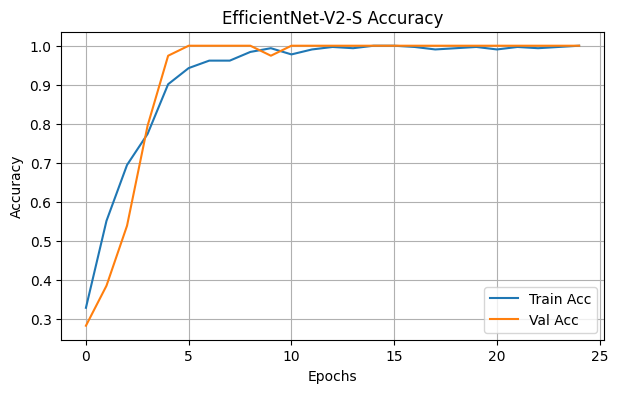

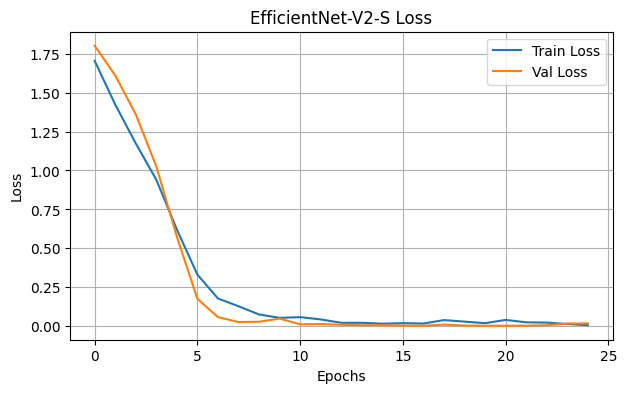


Final Test Accuracy: 0.8717948717948718


In [11]:
# ==========================================================
# EfficientNet-V2-S Training on dp_los_imagefolder
# Suhani Final Version — fully runnable
# ==========================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

ROOT = Path("dp_los_imagefolder")

# ----------------------------------------------------------
# 1. TRANSFORMS
# ----------------------------------------------------------
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

# ----------------------------------------------------------
# 2. LOAD DATASET
# ----------------------------------------------------------
train_ds = datasets.ImageFolder(ROOT/"train", transform=train_tf)
val_ds   = datasets.ImageFolder(ROOT/"val", transform=val_tf)
test_ds  = datasets.ImageFolder(ROOT/"test", transform=val_tf)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Classes:", train_ds.classes)
NUM_CLASSES = len(train_ds.classes)

# ----------------------------------------------------------
# 3. LOAD EfficientNet-V2-S
# ----------------------------------------------------------
model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ----------------------------------------------------------
# 4. TRAINING LOOP
# ----------------------------------------------------------
EPOCHS = 25
train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

best_acc = 0
best_path = "efficientnet_v2_s_dp_los_best.pth"

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = preds.max(1)
        correct += predicted.eq(y).sum().item()
        total += y.size(0)

    train_acc = correct/total
    train_loss = running_loss/len(train_dl)

    # -------- validation --------
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()

            _, predicted = preds.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

    val_acc = correct/total
    val_loss = val_loss/len(val_dl)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)

print("\nBest model saved:", best_path)

# ----------------------------------------------------------
# 5. TRAINING CURVES
# ----------------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("EfficientNet-V2-S Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("EfficientNet-V2-S Loss")
plt.legend()
plt.grid()
plt.show()

# ----------------------------------------------------------
# 6. TEST ACCURACY
# ----------------------------------------------------------
model.load_state_dict(torch.load(best_path))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        _, predicted = preds.max(1)
        correct += predicted.eq(y).sum().item()
        total += y.size(0)

print("\nFinal Test Accuracy:", correct/total)


In [ ]:
!pip install kneed


DP_LOS DBSCAN

In [ ]:
# WiSOM-style pipeline adapted to DP_LOS spectrogram PNGs
# Requirements: numpy, pandas, scikit-learn, matplotlib, pywt, imageio, kneed
# pip install scikit-learn matplotlib pywt imageio kneed

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import imageio
import pywt
from kneed import KneeLocator
import warnings
warnings.filterwarnings("ignore")

# -------- CONFIG ----------
ROOT = Path("dp_los_imagefolder")   # must contain train/val/test with class subfolders
SPLIT = "train"   # use train to tune DBSCAN, eval on test
MINPTS = 5        # DBSCAN min_samples
# --------------------------

def load_img_as_array(png_path):
    img = imageio.v2.imread(png_path)      # H x W x C or H x W
    if img.ndim == 3:
        img = img.mean(axis=2)             # convert to grayscale if needed
    # Convert to float and normalize
    arr = img.astype(np.float32)
    arr -= arr.min()
    if arr.max() > 0:
        arr /= arr.max()
    return arr  # shape freq x time (or H x W)

def extract_time_series_from_spec(spec2d, method="pca"):
    # spec2d: H x W (freq x time)
    if method == "mean":
        return spec2d.mean(axis=0)   # average across frequency → time series length W
    elif method == "pca":
        # we want the dominant temporal component -> PCA on freq dimension (rows)
        # treat columns (time) as samples for PCA: shape W x H
        p = PCA(n_components=1)
        try:
            comp = p.fit_transform(spec2d.T).flatten()
        except Exception:
            comp = spec2d.mean(axis=0)
        # normalize
        comp = (comp - np.mean(comp)) / (np.std(comp) + 1e-8)
        return comp
    else:
        raise ValueError("method mean or pca")

def wavelet_denoise(x, wavelet='db4', level=1):
    coeffs = pywt.wavedec(x, wavelet, mode='per')
    # zero small detail coefficients at first level
    thresh = np.median(np.abs(coeffs[-level])) / 0.6745 * np.sqrt(2*np.log(len(x)))
    coeffs[-level] = pywt.threshold(coeffs[-level], thresh, mode='soft')
    return pywt.waverec(coeffs, wavelet, mode='per')[:len(x)]

def build_dataset_features(root_split, method="pca", denoise=True):
    X = []
    y = []
    files = []
    for cls in sorted(os.listdir(root_split)):
        cls_dir = Path(root_split) / cls
        for f in sorted(os.listdir(cls_dir)):
            p = cls_dir / f
            spec = load_img_as_array(p)
            ts = extract_time_series_from_spec(spec, method=method)
            if denoise:
                ts = wavelet_denoise(ts)
            # feature: keep entire time series (you can compress, e.g., mean/energy)
            X.append(ts)
            y.append(int(cls))
            files.append(str(p))
    # Pad series to same length (they should be same if images same width)
    maxL = max(len(s) for s in X)
    Xp = np.array([np.pad(s, (0, maxL-len(s))) for s in X])
    return Xp, np.array(y), files

# Build features for train/val/test
X_train, y_train, files_train = build_dataset_features(ROOT/"train", method="pca")
X_val, y_val, files_val = build_dataset_features(ROOT/"val", method="pca")
X_test, y_test, files_test = build_dataset_features(ROOT/"test", method="pca")
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ---- Compute per-sample scalar features for clustering ----
# Option: energy/time-domain stats or compress via PCA on the time-series
def make_scalar_features(X):
    # Examples: energy, rms, std, spectral centroid approx (weighted mean index)
    feats = []
    for ts in X:
        energy = np.sum(ts**2)
        rms = np.sqrt(np.mean(ts**2))
        std = np.std(ts)
        meanv = np.mean(ts)
        # spectral centroid: index weighted by magnitude (approx.)
        mags = np.abs(np.fft.rfft(ts))
        freqs = np.arange(len(mags))
        cent = (np.sum(freqs*mags) / (np.sum(mags)+1e-8))
        feats.append([energy, rms, std, meanv, cent])
    return np.array(feats)

Feats_train = make_scalar_features(X_train)
Feats_test  = make_scalar_features(X_test)

# ---------- Auto-tune DBSCAN eps using k-distance (k = MINPTS) ----------
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=MINPTS).fit(Feats_train)
distances, indices = nbrs.kneighbors(Feats_train)
# use k-distance (distance to k-th neighbor) sorted
kdist = np.sort(distances[:, -1])
# knee detection
kneedle = KneeLocator(range(len(kdist)), kdist, S=1.0, curve='convex', direction='increasing', online=False)
knee_idx = kneedle.knee
if knee_idx is None:
    # fallback: pick value at 90th percentile
    eps = np.percentile(kdist, 90)
else:
    eps = float(kdist[knee_idx])
print("Auto-tuned eps:", eps)

# ---------- DBSCAN clustering on training features ----------
db = DBSCAN(eps=eps, min_samples=MINPTS).fit(Feats_train)
clusters = db.labels_
print("Clusters (train) unique:", np.unique(clusters), "— noise as -1")

# Map clusters to labels by majority vote (for evaluation)
cluster_to_label = {}
for cl in np.unique(clusters):
    if cl == -1:
        continue
    mask = clusters == cl
    majority = np.bincount(y_train[mask]).argmax()
    cluster_to_label[cl] = int(majority)
print("Cluster -> label mapping:", cluster_to_label)

# Predict on test using same pipeline: cluster assignment by nearest cluster centroid
# compute centroids for clusters (ignore noise)
centroids = {}
for cl in cluster_to_label:
    centroids[cl] = Feats_train[clusters==cl].mean(axis=0)

def assign_cluster(feat):
    # nearest centroid by Euclidean
    best_cl = -1
    best_d = 1e9
    for cl, c in centroids.items():
        d = np.linalg.norm(feat - c)
        if d < best_d:
            best_d = d
            best_cl = cl
    return best_cl

y_pred_clusters = []
for ft in Feats_test:
    cl = assign_cluster(ft)
    if cl == -1:
        y_pred_clusters.append(-1)
    else:
        y_pred_clusters.append(cluster_to_label[cl])

# Evaluate
mask_valid = np.array(y_pred_clusters) != -1
y_pred_mapped = np.array([ -1 if v==-1 else int(v) for v in y_pred_clusters ])
print("Test accuracy (ignoring noise):", accuracy_score(y_test[mask_valid], y_pred_mapped[mask_valid]) if mask_valid.any() else "no valid preds")
print("Overall accuracy (noise as wrong):", accuracy_score(y_test, np.where(y_pred_mapped==-1, -1, y_pred_mapped)))
print("\nClassification report (test, ignoring noise rows):")
from sklearn.metrics import classification_report
if mask_valid.any():
    print(classification_report(y_test[mask_valid], y_pred_mapped[mask_valid]))

# ---------- Control-chart per-sample detection (EWMA / z-score) ----------
# For online detection we build baseline from training samples of class 0 (no presence)
# Compute baseline mean/std of PCA-first-component signals
baseline_mask = (y_train == 0)    # assuming class 0 = "no presence"
if baseline_mask.sum() == 0:
    baseline_mean = 0
    baseline_std = 1
else:
    baseline_series = X_train[baseline_mask]   # N x T
    # build per-time mean/std (but simpler: global mean/std of PCA values)
    baseline_mean = baseline_series.mean()
    baseline_std = baseline_series.std()

print("Baseline mean/std (approx):", baseline_mean, baseline_std)

# For each test sample compute z-score of series mean and flag if abs(z) > threshold
threshold_z = 3.0
detections = []
for ts in X_test:
    score = (np.mean(ts) - baseline_mean) / (baseline_std + 1e-9)
    detections.append(1 if abs(score) > threshold_z else 0)

# Compare detection (1 => deviation/presence) vs ground truth (treat classes !=0 as presence)
gt_presence = (y_test != 0).astype(int)
from sklearn.metrics import confusion_matrix
print("Control-chart detection confusion matrix:")
print(confusion_matrix(gt_presence, detections))

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.plot(kdist); plt.title("k-distance sorted (used to choose DBSCAN eps)"); plt.ylabel("distance"); plt.xlabel("sorted index")
plt.axhline(eps, color='red', linestyle='--', label=f"eps={eps:.3f}")
plt.legend(); plt.show()
